In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from src.strategy import OptionStrategy
from src.greeks import GreeksDict
from src.utils import generate_range, simulate_contract_value_using_greeks

In [2]:
greeks_dict = GreeksDict(
    delta= .27,
    gamma = .12,
    theta = -0.0334,
    vega = 0.02,
)

strategy = OptionStrategy(
    underlying='PLTR',
    s0=30.62,
    r=0.0396
)

strategy.add_leg(
    contract_type='call',
    strike=31,
    contract_price=0.45,
    iv=0.55,
    greeks=greeks_dict,
    lot_size=1,
    expiration=datetime(2024, 8, 23)
)

In [3]:
price_range = generate_range(base_value=strategy.s0)
#time_range = np.arange(strategy.min_dte, 0, -1)

time_range = generate_range(base_value=strategy.min_dte, time=True)

vol_range = generate_range(base_value=strategy.net_iv)

In [4]:
simulated_value_from_price = simulate_contract_value_using_greeks(strategy.net_value, strategy.s0, price_range, strategy.net_greeks.delta, strategy.net_greeks.gamma)
simulated_value_from_time = simulate_contract_value_using_greeks(strategy.net_value, strategy.min_dte, time_range, strategy.net_greeks.theta, theta=True)
simulated_value_from_vol = simulate_contract_value_using_greeks(strategy.net_value, strategy.net_iv, vol_range, strategy.net_greeks.vega)

In [5]:
price_array = np.array([price_range, simulated_value_from_price])
time_array = np.array([time_range, simulated_value_from_time])
vol_array = np.array([vol_range, simulated_value_from_vol])

In [15]:
data = np.array(
    [
        price_array,
        time_array,
        vol_array,
    ]

)

In [25]:
index = pd.MultiIndex.from_product([['Price', 'Time', 'Volatility'], ['Variable Value', 'Estimated Contract Value']])

# Reshape the data to be 2D
reshaped_data = data.reshape(3 * price_array.shape[0], -1)

# Create a DataFrame
df = pd.DataFrame(reshaped_data, index=index).T


In [26]:
df

Price                                    Time  \
   Variable Value Estimated Contract Value Variable Value   
0       29.089000                 0.317905       5.000000   
1       29.151490                 0.312285       4.897959   
2       29.213980                 0.307602       4.795918   
3       29.276469                 0.303856       4.693878   
4       29.338959                 0.301047       4.591837   
5       29.401449                 0.299175       4.489796   
6       29.463939                 0.298241       4.387755   
7       29.526429                 0.298244       4.285714   
8       29.588918                 0.299183       4.183673   
9       29.651408                 0.301061       4.081633   
10      29.713898                 0.303875       3.979592   
11      29.776388                 0.307626       3.877551   
12      29.838878                 0.312315       3.775510   
13      29.901367                 0.317941       3.673469   
14      29.963857                 0.324504       3.571429   
15      30.026347                 0.332005       3.469388   
16      30.088837                 0.340442       3.367347   
17      30.151327                 0.349817       3.265306   
18      30.213816                 0.360129       3.163265   
19      30.276306                 0.371378       3.061224   
20      30.338796                 0.383564       2.959184   
21      30.401286                 0.396687       2.857143   
22      30.463776                 0.410748       2.755102   
23      30.526265                 0.425746       2.653061   
24      30.588755                 0.441681       2.551020   
25      30.651245                 0.458553       2.448980   
26      30.713735                 0.476363       2.346939   
27      30.776224                 0.495109       2.244898   
28      30.838714                 0.514793       2.142857   
29      30.901204                 0.535414       2.040816   
30      30.963694                 0.556972       1.938776   
31      31.026184                 0.579468       1.836735   
32      31.088673                 0.602900       1.734694   
33      31.151163                 0.627270       1.632653   
34      31.213653                 0.652577       1.530612   
35      31.276143                 0.678821       1.428571   
36      31.338633                 0.706003       1.326531   
37      31.401122                 0.734121       1.224490   
38      31.463612                 0.763177       1.122449   
39      31.526102                 0.793170       1.020408   
40      31.588592                 0.824100       0.918367   
41      31.651082                 0.855968       0.816327   
42      31.713571                 0.888772       0.714286   
43      31.776061                 0.922514       0.612245   
44      31.838551                 0.957193       0.510204   
45      31.901041                 0.992809       0.408163   
46      31.963531                 1.029362       0.306122   
47      32.026020                 1.066853       0.204082   
48      32.088510                 1.105280       0.102041   
49      32.151000                 1.144645       0.000000   

                                Volatility                           
   Estimated Contract Value Variable Value Estimated Contract Value  
0                  0.450000       0.522500                 0.449450  
1                  0.446592       0.523622                 0.449472  
2                  0.443184       0.524745                 0.449495  
3                  0.439776       0.525867                 0.449517  
4                  0.436367       0.526990                 0.449540  
5                  0.432959       0.528112                 0.449562  
6                  0.429551       0.529235                 0.449585  
7                  0.426143       0.530357                 0.449607  
8                  0.422735       0.531480                 0.449630  
9                  0.419327       0.532602                 0.449652  

In [32]:
import matplotlib.pyplot as plt

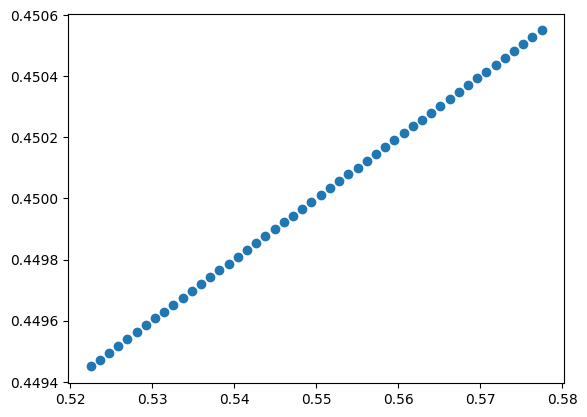

In [36]:
plt.scatter(x = df['Volatility']['Variable Value'], y = df['Volatility']['Estimated Contract Value'])